In [1]:
import os
import glob
import numpy as np
import random
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras import regularizers, initializers, optimizers
from tensorflow.keras import applications, preprocessing, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [2]:
dataset_path ='dataset/trainingSet/trainingSet'
my_image_size = (28,28)
my_batch_size = 100
my_seed = 123456789

train_dataset, test_dataset = preprocessing.image_dataset_from_directory(
    directory = dataset_path,
    color_mode = 'grayscale',
    label_mode = 'categorical',  
    shuffle = True,
    seed = my_seed,
    validation_split = 0.2,
    subset = "both",
    image_size = my_image_size,
    batch_size = my_batch_size,
)

Found 42000 files belonging to 10 classes.
Using 33600 files for training.
Using 8400 files for validation.


In [3]:
print(train_dataset);
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [5]:
x, y = zip(*train_dataset)
X_train = np.concatenate(x)
y_train = np.concatenate(y)

x, y = zip(*test_dataset)
X_test = np.concatenate(x)
y_test = np.concatenate(y)

In [6]:
print(y_train.shape)
print(y_test.shape)

(33600, 10)
(8400, 10)


In [7]:
class_names=np.array(train_dataset.class_names)
print(class_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


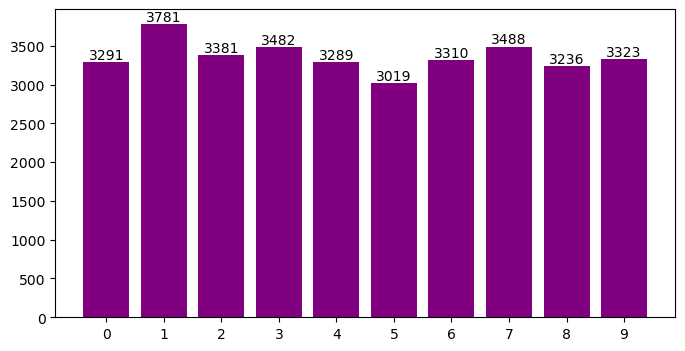

In [10]:
class_names=train_dataset.class_names
count_by_class_train = [0] * len(class_names)

for images, labels in train_dataset:
    label_indices = tf.argmax(labels, axis=1).numpy()
    for index in label_indices:
        count_by_class_train[index] += 1

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
bars = ax.bar(class_names, count_by_class_train, color = 'purple')
ax.bar_label(bars);

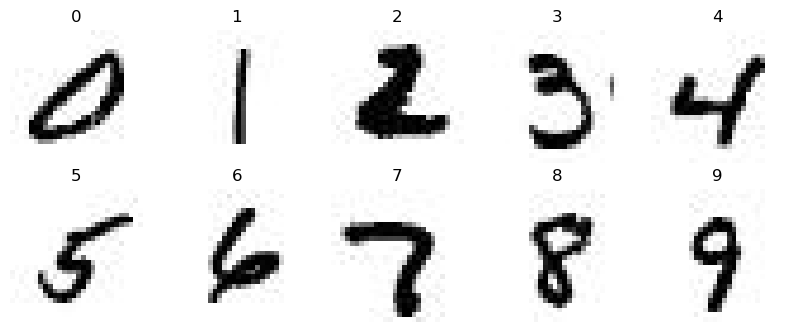

In [25]:
plt.figure(figsize=(10, 10), dpi=100)

for i in range(10):               
    x = X_train[(np.argmax(y_train, axis=1) == i)]        
    #print(x.shape, class_names[i])
    x = np.array(random.choices(x, k=1))                   
    ax = plt.subplot(5, 5, i + 1 )
    plt.imshow(x[0,:,:,0].astype("uint8"), cmap = "binary",vmin=0, vmax=255)    
    plt.title(class_names[i])
    plt.axis("off")

In [12]:
k_ini=initializers.RandomNormal(seed=my_seed, mean=0., stddev=0.15)
b_ini=initializers.Zeros()


initial_lr = 0.0001


In [13]:
weights_path='weights'
os.makedirs(weights_path, exist_ok=True)  


my_callbacks = [
    callbacks.ModelCheckpoint(filepath=os.path.join(weights_path,
                                    'model{epoch:02d}_loss{val_loss:.2f}.weights.h5'),
                                     save_best_only=True, save_weights_only = True),
]

In [14]:
my_input_shape=(28,28,1)
num_classes=len(class_names)


custom_model = keras.Sequential([
    layers.InputLayer(my_input_shape),
    layers.Rescaling(scale = 2.0 / 255.0, offset = -1.0), 
    
    
    Conv2D(filters=8, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer=k_ini, bias_initializer=b_ini), 
    Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer=k_ini, bias_initializer=b_ini),
    Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer=k_ini, bias_initializer=b_ini),  
    layers.Flatten(),
    
    
    Dense(32, activation='relu', kernel_initializer=k_ini, bias_initializer=b_ini), 
    Dense(16, activation='relu', kernel_initializer=k_ini, bias_initializer=b_ini), 
    Dense(num_classes, activation='softmax')  
])

custom_model.compile(optimizer = optimizers.Adam(learning_rate=initial_lr), 
                     loss = 'categorical_crossentropy', metrics = ['accuracy'])   

custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 16)                5

In [15]:
initial_epoch = 0
epochs = 20


history = custom_model.fit(    train_dataset,   
                               validation_data=test_dataset,
                               epochs=epochs,
                               initial_epoch=initial_epoch,
                               callbacks=[my_callbacks]
)

Epoch 1/20
336/336 [==============================] - 77s 224ms/step - loss: 1.8738 - accuracy: 0.3758 - val_loss: 1.2210 - val_accuracy: 0.6451
Epoch 2/20
336/336 [==============================] - 36s 106ms/step - loss: 0.8117 - accuracy: 0.7602 - val_loss: 0.6178 - val_accuracy: 0.8139
Epoch 3/20
336/336 [==============================] - 38s 114ms/step - loss: 0.5150 - accuracy: 0.8468 - val_loss: 0.4718 - val_accuracy: 0.8589
Epoch 4/20
336/336 [==============================] - 35s 103ms/step - loss: 0.4149 - accuracy: 0.8759 - val_loss: 0.4097 - val_accuracy: 0.8783
Epoch 5/20
336/336 [==============================] - 36s 108ms/step - loss: 0.3612 - accuracy: 0.8924 - val_loss: 0.3653 - val_accuracy: 0.8924
Epoch 6/20
336/336 [==============================] - 67s 198ms/step - loss: 0.3241 - accuracy: 0.9038 - val_loss: 0.3359 - val_accuracy: 0.9035
Epoch 7/20
336/336 [==============================] - 39s 112ms/step - loss: 0.2962 - accuracy: 0.9129 - val_loss: 0.3117 - val_ac

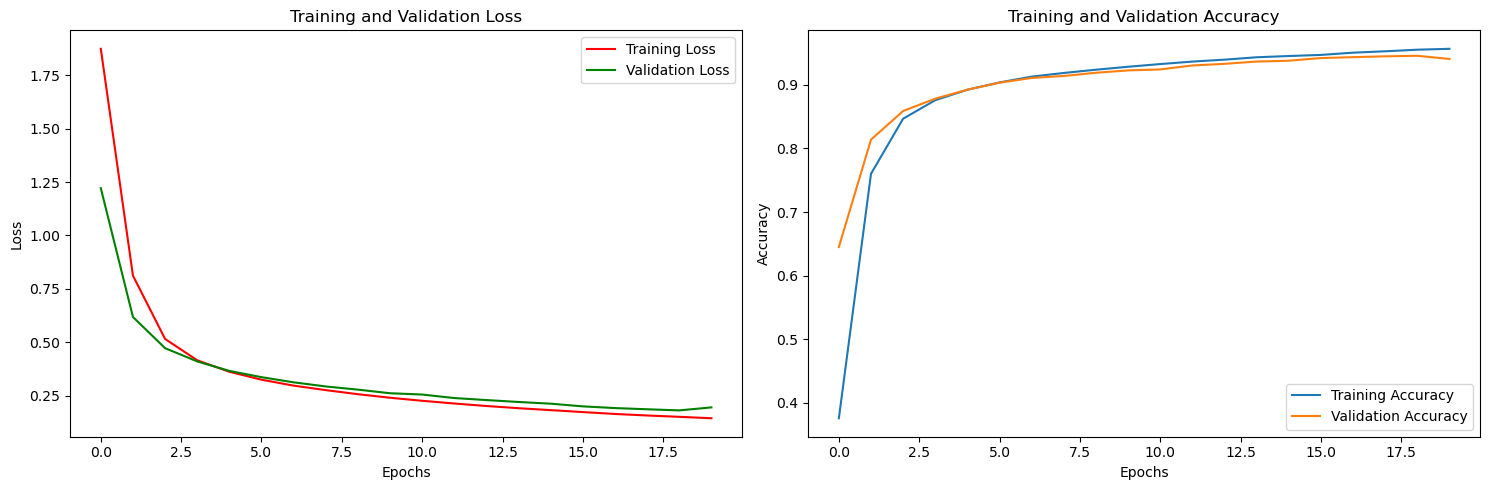

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=100)


ax1.plot(history.history['loss'], label='Training Loss', color = 'red')
ax1.plot(history.history['val_loss'], label='Validation Loss', color = 'green')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss'); ax1.legend()


ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy'); ax2.legend()

plt.tight_layout(); plt.show()

In [17]:
best_epoch = 20

file_name = f"model{best_epoch:02d}_loss????.weights.h5"
file_dir = glob.glob(os.path.join(weights_path, file_name))

best_model=custom_model
best_model.load_weights(file_dir[0])


best_model.evaluate(train_dataset)
best_model.evaluate(test_dataset)

84/84 [==============================] - 2s 19ms/step - loss: 0.1576 - accuracy: 0.9498


[0.157588928937912, 0.9497619271278381]

In [18]:

y_test_pred = best_model.predict(X_test)

print(classification_report_imbalanced(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))

263/263 [==============================] - 1s 2ms/step
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.97      1.00      0.97      0.98      0.97       841
          1       0.99      0.97      1.00      0.98      0.98      0.97       903
          2       0.92      0.97      0.99      0.94      0.98      0.96       796
          3       0.93      0.92      0.99      0.93      0.96      0.91       869
          4       0.94      0.96      0.99      0.95      0.98      0.95       783
          5       0.97      0.95      1.00      0.96      0.97      0.94       776
          6       0.96      0.98      1.00      0.97      0.99      0.97       827
          7       0.96      0.93      1.00      0.95      0.96      0.92       913
          8       0.93      0.91      0.99      0.92      0.95      0.89       827
          9       0.92      0.95      0.99      0.93      0.97      0.94       865

avg / total       0.95      0.

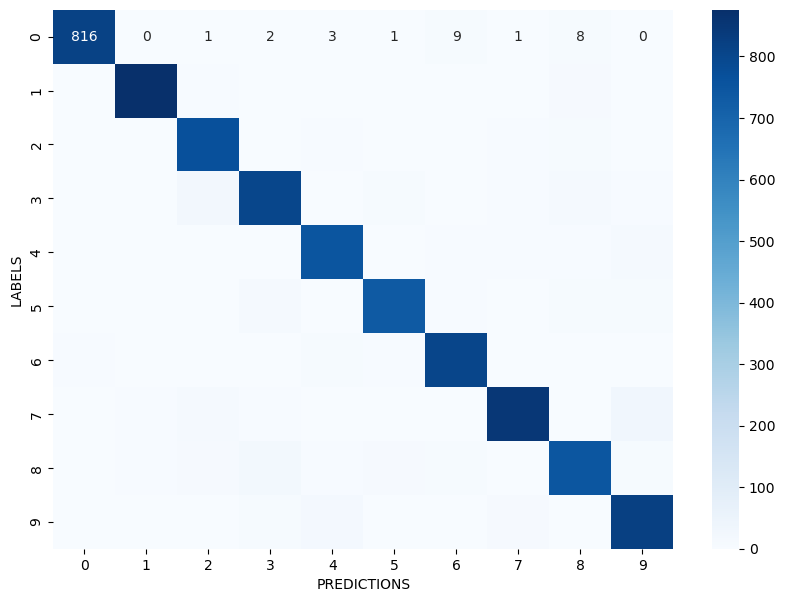

In [19]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)) 

plt.figure(figsize = (10,7), dpi=100)
ax = sn.heatmap(cm, annot=True, fmt=".0f", cmap = "Blues", 
                        xticklabels=class_names, yticklabels=class_names)
ax.set(xlabel="PREDICTIONS", ylabel="LABELS");

In [22]:
def plot_class_vs_class(cl_a = 3 , cl_b = 8, images_per_row = 3):

    n_class = 2
    n_images = images_per_row * images_per_row
    
    y_t_1dim = np.argmax(y_test, axis=1)
    y_p_1dim = np.argmax(y_test_pred, axis=1)
    
    x1 = X_test[(y_t_1dim == cl_a) & (y_p_1dim == cl_a)] 
    x2 = X_test[(y_t_1dim == cl_a) & (y_p_1dim == cl_b)] 
    x3 = X_test[(y_t_1dim == cl_b) & (y_p_1dim == cl_a)] 
    x4 = X_test[(y_t_1dim == cl_b) & (y_p_1dim == cl_b)] 
    
    x1=np.array(random.choices(x1, k=n_images))   
    x2=np.array(random.choices(x2, k=n_images))
    x3=np.array(random.choices(x3, k=n_images))
    x4=np.array(random.choices(x4, k=n_images))

    X = np.stack([x1, x2, x3, x4])

    fig = plt.figure(figsize=(10, 10), dpi=150)

    
    outer_grid = gridspec.GridSpec(n_class, n_class, wspace=0.10, hspace=0.10)

    for i in range(n_class*n_class):
        inner_grid = gridspec.GridSpecFromSubplotSpec(images_per_row, images_per_row,
                subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
        
        for j in range(n_images):
            ax = plt.Subplot(fig, inner_grid[j])
            ax.imshow(X[i,j,:,:,0].astype(np.uint8), cmap = "gray",vmin=0, vmax=255) 
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    all_axes = fig.get_axes()
    
    
    ax_left = fig.add_subplot(outer_grid[0])
    ax_left.axis('off')
    ax_left.set_title(f'Label={class_names[cl_a]}  Prediction={class_names[cl_a]}')

    ax_right = fig.add_subplot(outer_grid[1])
    ax_right.axis('off')
    ax_right.set_title(f'Label={class_names[cl_a]}  Prediction={class_names[cl_b]}')
    
    ax_left = fig.add_subplot(outer_grid[2])
    ax_left.axis('off')
    ax_left.set_title(f'Label={class_names[cl_b]}  Prediction={class_names[cl_a]}')

    ax_right = fig.add_subplot(outer_grid[3])
    ax_right.axis('off')
    ax_right.set_title(f'Label={class_names[cl_b]}  Prediction={class_names[cl_b]}')

    plt.show()

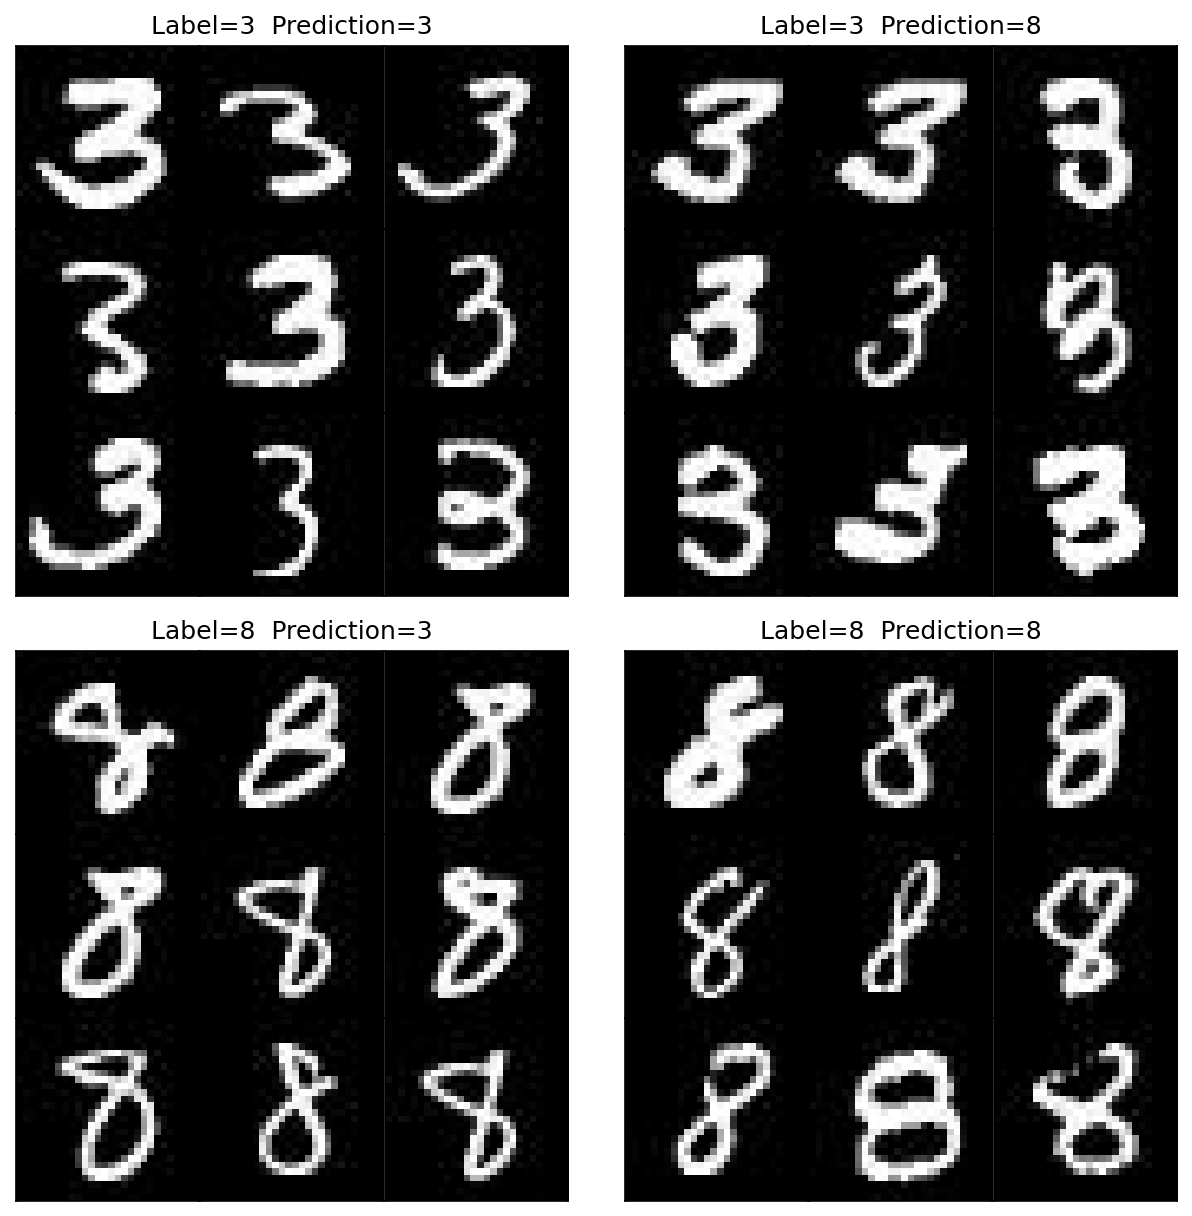

In [23]:
plot_class_vs_class(3, 8, 3)

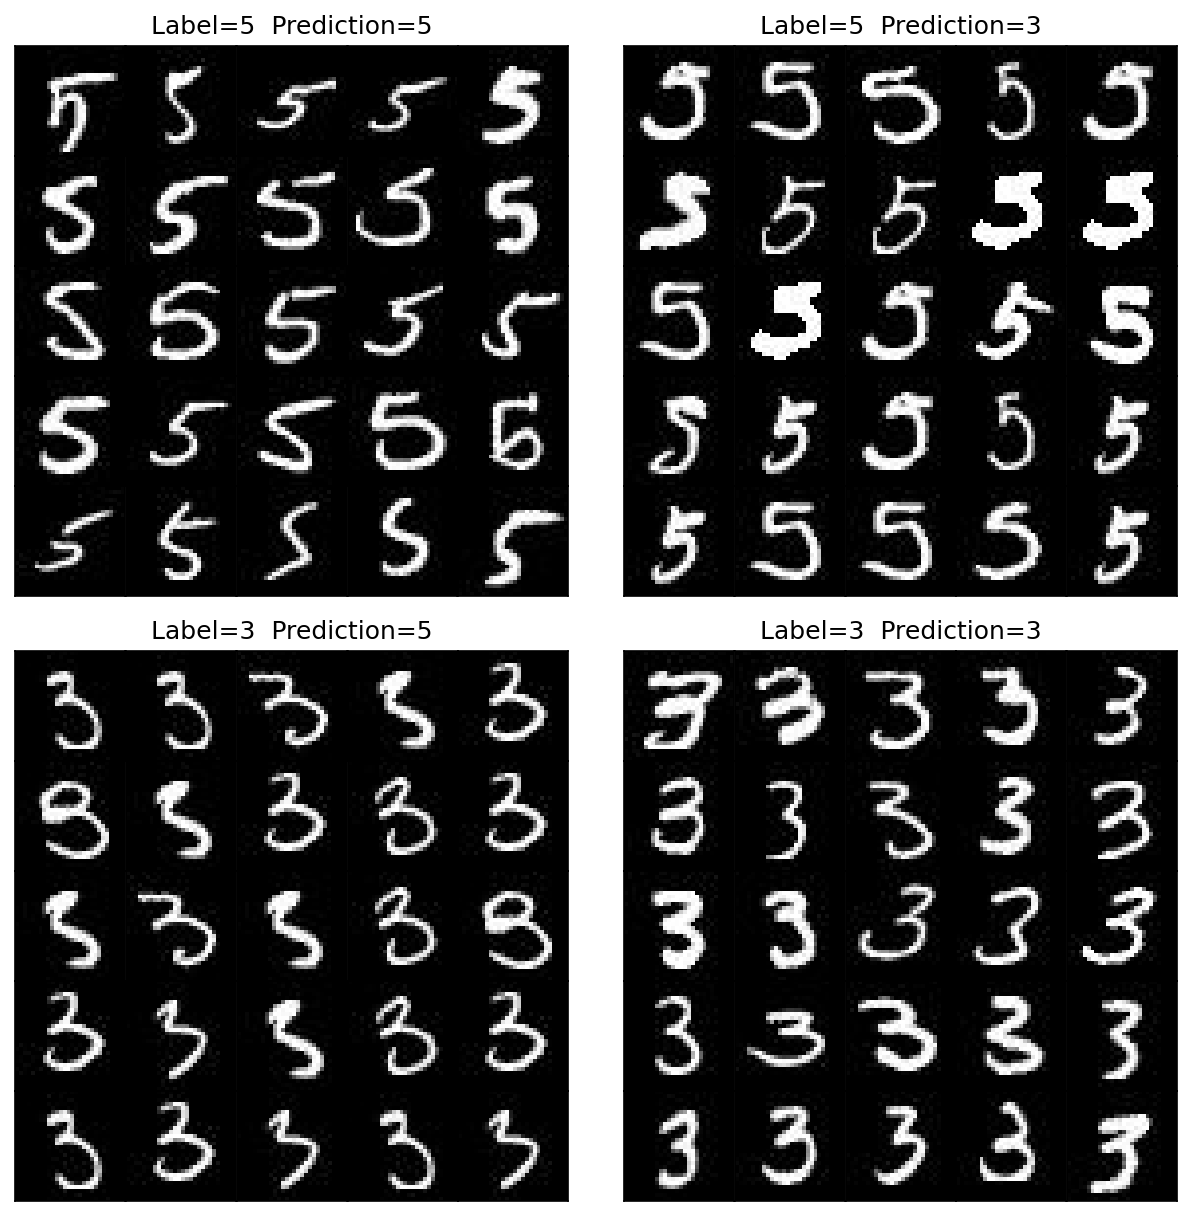

In [24]:
plot_class_vs_class(cl_a = 5 , cl_b = 3, images_per_row = 5)